### TP5 options

Libraries import

In [1]:
import numpy                 as np
import matplotlib.pyplot     as plt
import pandas                as pd
import tensorflow            as tf
import yfinance              as yf

from tensorflow              import keras
from keras.models            import Model
from keras.layers            import Input, Dense
from scipy                   import stats
from scipy.stats             import norm 
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

Data import and preparation

In [2]:
Options=pd.read_csv('ES_options.csv') #change path accordingly

In [3]:
ES=yf.Ticker('ES=F') #uploading daily underlying data
Es_prices=ES.history(start='2008-01-05',auto_adjust=True)

In [4]:
Options['mid_option']=(Options['ask']+Options['bid'])/2
Options['relative_spread']=(Options['ask']-Options['bid'])/Options['mid_option']
Options['strike_scaled']=Options['strike']/Options['mid']
Options['mid_scaled']=Options['mid_option']/Options['mid']

Adding volatility

In [5]:
Es_prices['a']=np.log(Es_prices['High']/Es_prices['Close'])*np.log(Es_prices['High']/Es_prices['Open'])
Es_prices['b']=np.log(Es_prices['Low']/Es_prices['Close'])*np.log(Es_prices['Low']/Es_prices['Open'])
Es_prices['RS']=Es_prices['a']+Es_prices['b']
Es_prices.drop(columns=['a','b'],inplace=True)
Es_prices['7_days_volatility']=np.sqrt(Es_prices['RS'].rolling(window=7,min_periods=1).mean())*np.sqrt(252)
Es_prices['14_days_volatility']=np.sqrt(Es_prices['RS'].rolling(window=14,min_periods=1).mean())*np.sqrt(252)
Es_prices['49_days_volatility']=np.sqrt(Es_prices['RS'].rolling(window=49,min_periods=1).mean())*np.sqrt(252)

In [6]:
Es_prices=Es_prices.reset_index()
Es_prices['Date']=Es_prices['Date'].apply(lambda x:x.date())

In [7]:
Options['index']=pd.to_datetime(Options['index'])
Options['Date']=Options['index'].apply(lambda x:x.date())

In [8]:
columns=['Date','7_days_volatility','14_days_volatility','49_days_volatility']
all_data=pd.merge(Options,Es_prices[columns],how='left',left_on=['Date'],right_on=['Date'])

Adding Black and Scholes prices

In [9]:
def BS_price(S0,K,T,sigma,r=0,option_type='call'):
    d1 = (np.log(S0/K) + (r+((sigma**2)/2)*T))/(sigma*np.sqrt(T)) 
    d2 = d1 - (sigma*np.sqrt(T)) 
    price=(S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2))

    if option_type=='put':
        price-(S0- K*np.exp(-r*T))
    return price

In [10]:
def calculate_bs_price(df):

    BS_prices=[]

    for index, row in df.iterrows():
        if (row['option_type'] == 'call'):
            price= BS_price(1, row['strike_scaled'], row['days_to_expiry']/365, row['14_days_volatility'], r=0,option_type='call')
        elif (row['option_type'] == 'Put'):
            price= BS_price(1, row['strike_scaled'], row['days_to_expiry']/365, row['14_days_volatility'], r=0,option_type='put')
        BS_prices.append(price)
        
    return BS_prices

In [11]:
BS_prices=calculate_bs_price(all_data)
all_data['BS_price'] = BS_prices

In [12]:
Options=all_data.copy().dropna()

In [13]:
# 60% Train, 20% Validation, 20% Test
N = len(Options)
Train_data_1_size = int(0.6*N)
Validatin_data_1_size = int(0.2*N)

In [288]:
def Split_data(selcted_columns):
    # Prparing Training Validation and Test data
    X = Options.loc[:, selcted_columns].copy().values
    Y=  Options['mid_scaled'].copy().values
    
    # Split the data into training, validation, and test sets
    X_train = X[:Train_data_1_size, :]
    Y_train = Y[:Train_data_1_size]

    X_validation = X[Train_data_1_size:Train_data_1_size + Validatin_data_1_size, :]
    Y_validation = Y[Train_data_1_size:Train_data_1_size + Validatin_data_1_size]

    X_test = X[Train_data_1_size + Validatin_data_1_size:, :]
    Y_test = Y[Train_data_1_size + Validatin_data_1_size:]

    return X_train,Y_train,X_validation,Y_validation,X_test,Y_test

In [289]:
def DNN(N_input,act='tanh'):

    model = keras.models.Sequential()
    model.add (Dense(12, input_dim=N_input, activation=act ))
    model.add (Dense(12, activation=act ))
    model.add (Dense(12, activation=act ))
    model.add (Dense(12, activation=act ))
    model.add (Dense(1, activation=act ))

    model.compile(loss='mse', optimizer='adam')
    
    return model

In [46]:
# Boolean values that are True if model is already trained no need to train, change to False otherwise
Trained_model_1=False
Trained_model_2=False
Trained_model_3=False
Trained_model_put_call=False
Trained_model_put_call_custom=False

Incomplete parameters

In [291]:
selected_columns_1 = ['strike_scaled', 'days_to_expiry', 'relative_spread']
X_train_1,Y_train_1,X_validation_1,Y_validation_1,X_test_1,Y_test_1=Split_data(selected_columns_1)
N_1=X_train_1.shape[1]

In [292]:
model_1=DNN(N_1)
model_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 12)                48        
                                                                 
 dense_76 (Dense)            (None, 12)                156       
                                                                 
 dense_77 (Dense)            (None, 12)                156       
                                                                 
 dense_78 (Dense)            (None, 12)                156       
                                                                 
 dense_79 (Dense)            (None, 1)                 13        
                                                                 
Total params: 529 (2.07 KB)
Trainable params: 529 (2.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [293]:
if Trained_model_1==False:
    model_1.fit(X_train_1,Y_train_1,batch_size=64,epochs=30)
    save_model(model_1, 'model_1.h5')
else:
    model_1=load_model('model_1.h5')

Epoch 1/30


1120/1120 [==============================] - 4s 2ms/step - loss: 0.0058
Epoch 2/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 3/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0033
Epoch 4/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0033
Epoch 5/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0031
Epoch 6/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 7/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 8/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 9/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 10/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 11/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0025
Epoch 12/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0022
Epoch 13/30


C:\Users\Win10-Space\AppData\Local\Temp\ipykernel_22280\47525652.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_1, 'model_1.h5')


In [294]:
Y_predict_1=model_1.predict(X_test_1)

747/747 [==============================] - 2s 2ms/step


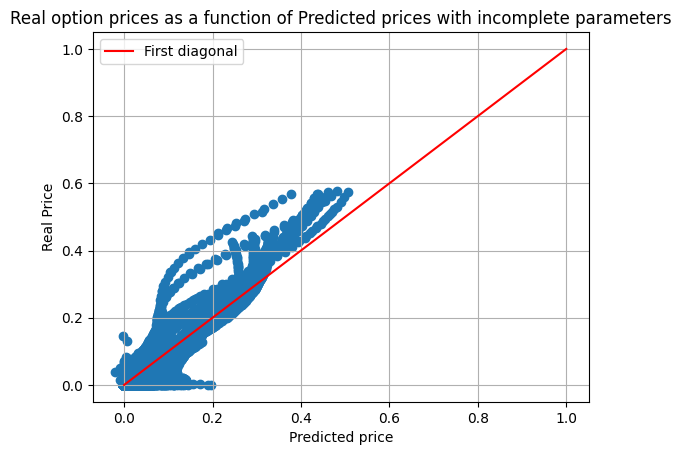

In [296]:
diagonal=np.linspace(0,1,50)
plt.scatter(Y_predict_1,Y_test_1)
plt.plot(diagonal,diagonal,color='r', label='First diagonal')
plt.xlabel('Predicted price')
plt.ylabel('Real Price')
plt.title('Real option prices as a function of Predicted prices with incomplete parameters')
plt.grid()
plt.legend()
plt.show()

The NN seems to undervalue the real price as the scatter plot of (real price=f(predicted price) is mainly above the first diagonal)

In [300]:
#Prediction precision metrics
MAE_1=np.mean(np.abs(Y_predict_1-Y_test_1))/np.mean(Y_test_1) #Mean absolute error (relative to the magnitutde of Y_test)
MSE_1=np.mean((Y_predict_1-Y_test_1)**2)/np.mean(Y_test_1)  #Mean square error (relative to the magnitutde of Y_test)

print('Mean absolute error : '+ str(MAE_1))
print('Mean square error : '+ str(MSE_1))

Mean absolute error : 1.6498746159577504
Mean square error : 0.24101852214693026


In [301]:
#Fraction of predictions in the spread

relative_bids_1=(Options.loc[Train_data_1_size + Validatin_data_1_size:,'bid']/Options.loc[Train_data_1_size + Validatin_data_1_size:,'mid']).values
relative_asks_1=(Options.loc[Train_data_1_size + Validatin_data_1_size:,'ask']/Options.loc[Train_data_1_size + Validatin_data_1_size:,'mid']).values
Prediction_in_spread_1=np.mean((Y_predict_1 >= relative_bids_1 ) & (Y_predict_1 <= relative_asks_1 ))
print(Prediction_in_spread_1)

0.00823456534190099


Incomplete parameters + relative spread + Volatility 

In [302]:
selected_columns_2 = ['strike_scaled', 'days_to_expiry', 'relative_spread','14_days_volatility']
X_train_2,Y_train_2,X_validation_2,Y_validation_2,X_test_2,Y_test_2=Split_data(selected_columns_2)

In [303]:
N_2=X_train_2.shape[1]
model_2=DNN(N_2)
model_2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 12)                60        
                                                                 
 dense_81 (Dense)            (None, 12)                156       
                                                                 
 dense_82 (Dense)            (None, 12)                156       
                                                                 
 dense_83 (Dense)            (None, 12)                156       
                                                                 
 dense_84 (Dense)            (None, 1)                 13        
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [304]:
if Trained_model_2==False:
    model_2.fit(X_train_2,Y_train_2,batch_size=64,epochs=30)
    save_model(model_2, 'model_2.h5')
else:
    model_2=load_model('model_2.h5')

Epoch 1/30
1120/1120 [==============================] - 11s 3ms/step - loss: 0.0040
Epoch 2/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0038
Epoch 3/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0036
Epoch 4/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0033
Epoch 5/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0031
Epoch 6/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0030
Epoch 7/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0029
Epoch 8/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0028
Epoch 9/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0027
Epoch 10/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0026
Epoch 11/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0026
Epoch 12/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0026


C:\Users\Win10-Space\AppData\Local\Temp\ipykernel_22280\1707029311.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_2, 'model_2.h5')


In [305]:
Y_predict_2=model_2.predict(X_test_2)

747/747 [==============================] - 2s 2ms/step


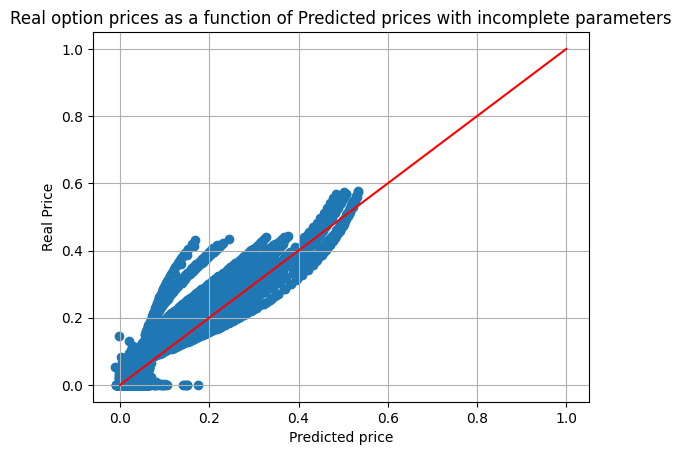

In [307]:
plt.scatter(Y_predict_2,Y_test_2)
plt.plot(diagonal,diagonal,color='r', label='First diagonal')
plt.xlabel('Predicted price')
plt.ylabel('Real Price')
plt.title('Real option prices as a function of Predicted prices with incomplete parameters')
plt.grid()
plt.show()

Adding the relative spread and the volatility seems to have improved a bit the results. the scatter seems now a little more centeres around the first diagonal.
Below MSE and MAE have decreased compared to the previous case

In [308]:
#Prediction precision metrics
MAE_2=np.mean(np.abs(Y_predict_2-Y_test_2))/np.mean(Y_test_2) #Mean absolute error (relative to the magnitutde of Y_test)
MSE_2=np.mean((Y_predict_2-Y_test_2)**2)/np.mean(Y_test_2)  #Mean square error (relative to the magnitutde of Y_test)

print('Mean absolute error : '+ str(MAE_2))
print('Mean square error : '+ str(MSE_2))

Mean absolute error : 1.4483725309313877
Mean square error : 0.2229410277929692


In [311]:
#Fraction of predictions in the spread
relative_bids_2=(Options.loc[Train_data_1_size + Validatin_data_1_size:,'bid']/Options.loc[Train_data_1_size + Validatin_data_1_size:,'mid']).values
relative_asks_2=(Options.loc[Train_data_1_size + Validatin_data_1_size:,'ask']/Options.loc[Train_data_1_size + Validatin_data_1_size:,'mid']).values
Prediction_in_spread_2=np.mean((Y_predict_2 >= relative_bids_2) & (Y_predict_2 <= relative_asks_2))
print(Prediction_in_spread_2)

0.007835197422262186


Incomplete parameters + relative spread + Volatility + Black and Scholes price

In [312]:
selected_columns_3 = ['strike_scaled', 'days_to_expiry', 'relative_spread','14_days_volatility','BS_price']
X_train_3,Y_train_3,X_validation_3,Y_validation_3,X_test_3,Y_test_3=Split_data(selected_columns_3)

In [313]:
N_3=X_train_3.shape[1]
model_3=DNN(N_3)
model_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 12)                72        
                                                                 
 dense_86 (Dense)            (None, 12)                156       
                                                                 
 dense_87 (Dense)            (None, 12)                156       
                                                                 
 dense_88 (Dense)            (None, 12)                156       
                                                                 
 dense_89 (Dense)            (None, 1)                 13        
                                                                 
Total params: 553 (2.16 KB)
Trainable params: 553 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [314]:
if Trained_model_3==False:
    model_3.fit(X_train_3,Y_train_3,batch_size=64,epochs=30)
    save_model(model_3, 'model_3.h5')
else:
    model_3=load_model('model_3.h5')

Epoch 1/30
1120/1120 [==============================] - 8s 3ms/step - loss: 0.0047
Epoch 2/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0032
Epoch 3/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0030
Epoch 4/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0029
Epoch 5/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0027
Epoch 6/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0026
Epoch 7/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0026
Epoch 8/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0024
Epoch 9/30
1120/1120 [==============================] - 3s 2ms/step - loss: 0.0023
Epoch 10/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0023
Epoch 11/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0020
Epoch 12/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0019
E

C:\Users\Win10-Space\AppData\Local\Temp\ipykernel_22280\451908169.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_3, 'model_3.h5')


In [315]:
Y_predict_3=model_3.predict(X_test_3)

747/747 [==============================] - 2s 2ms/step


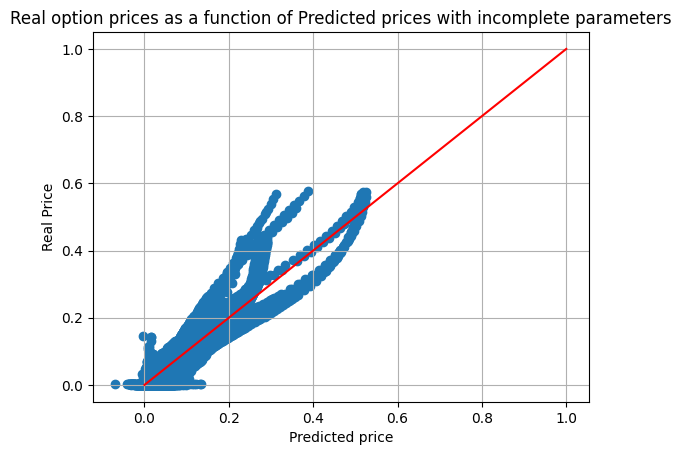

In [317]:
plt.scatter(Y_predict_3,Y_test_3)
plt.plot(diagonal,diagonal,color='r', label='First diagonal')
plt.xlabel('Predicted price')
plt.ylabel('Real Price')
plt.title('Real option prices as a function of Predicted prices with incomplete parameters')
plt.grid()
plt.show()

It is hard to judge whether the predection has improved or not. Using the below metrics we find less better results than in the case without Black_and_Scholes prices.

In [318]:
#Prediction precision metrics
MAE_3=np.mean(np.abs(Y_predict_3-Y_test_3))/np.mean(Y_test_3) #Mean absolute error (relative to the magnitutde of Y_test)
MSE_3=np.mean((Y_predict_3-Y_test_3)**2)/np.mean(Y_test_3)   #Mean square error (relative to the magnitutde of Y_test)

print('Mean absolute error : '+ str(MAE_3))
print('Mean square error : '+ str(MSE_3))

Mean absolute error : 1.5483997565905874
Mean square error : 0.2302987035775215


In [319]:
#Fraction of predictions in the spread
relative_bids_3=(Options.loc[Train_data_1_size + Validatin_data_1_size:,'bid']/Options.loc[Train_data_1_size + Validatin_data_1_size:,'mid']).values
relative_asks_3=(Options.loc[Train_data_1_size + Validatin_data_1_size:,'ask']/Options.loc[Train_data_1_size + Validatin_data_1_size:,'mid']).values
Prediction_in_spread_3=np.mean((Y_predict_3 >= relative_bids_3) & (Y_predict_3 <= relative_asks_3))
print(Prediction_in_spread_3)

0.007912181979409892


Put Call parity

In [14]:
#creating a new data frame, each line is a call option and put of option of same strike and maturity
Call_Options = Options[Options['option_type'] == 'call']
Put_Options = Options[Options['option_type'] == 'put']

Put_Call_options = pd.merge(Call_Options, Put_Options, on=['index', 'mid','strike','days_to_expiry','expiry'], suffixes=('_call', '_put'))

In [72]:
# 60% Train, 20% Validation, 20% Test
N_pc = len(Put_Call_options)
Train_data_2_size = int(0.6*N_pc)
Validatin_data_2_size = int(0.2*N_pc)

In [60]:
def Split_data_pc(selcted_columns):
    # Prparing Training Validation and Test data
    X = Put_Call_options.loc[:, selcted_columns].copy().values
    Y=  Put_Call_options[['mid_scaled_call','mid_scaled_put']].copy().values
    
    # Split the data into training, validation, and test sets
    X_train = X[:Train_data_2_size, :]
    Y_train = Y[:Train_data_2_size]

    X_validation = X[Train_data_2_size:Train_data_2_size + Validatin_data_2_size, :]
    Y_validation = Y[Train_data_2_size:Train_data_2_size + Validatin_data_2_size]

    X_test = X[Train_data_2_size + Validatin_data_2_size:, :]
    Y_test = Y[Train_data_2_size + Validatin_data_2_size:]

    return X_train,Y_train,X_validation,Y_validation,X_test,Y_test

In [61]:
def DNN_pc(N_input,act='tanh'):

    model = keras.models.Sequential()
    model.add (Dense(12, input_dim=N_input, activation=act ))
    model.add (Dense(12, activation=act ))
    model.add (Dense(12, activation=act ))
    model.add (Dense(12, activation=act ))
    model.add (Dense(2, activation=act ))

    model.compile(loss='mse', optimizer='adam')
    
    return model

In [62]:
selected_columns_pc = ['strike_scaled_call', 'days_to_expiry', 'relative_spread_call','relative_spread_put','14_days_volatility_call','BS_price_call']
X_train_pc,Y_train_pc,X_validation_pc,Y_validation_pc,X_test_pc,Y_test_pc=Split_data_pc(selected_columns_pc)

In [63]:
N_pc_1=X_train_pc.shape[1]
model_pc=DNN_pc(N_pc_1)
model_pc.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12)                84        
                                                                 
 dense_16 (Dense)            (None, 12)                156       
                                                                 
 dense_17 (Dense)            (None, 12)                156       
                                                                 
 dense_18 (Dense)            (None, 12)                156       
                                                                 
 dense_19 (Dense)            (None, 2)                 26        
                                                                 
Total params: 578 (2.26 KB)
Trainable params: 578 (2.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
if Trained_model_put_call==False:
    model_pc.fit(X_train_pc,Y_train_pc,batch_size=64,epochs=30)
    save_model(model_pc, 'model_pc.h5')
else:
    model_pc=load_model('model_pc.h5')

Epoch 1/30
389/389 [==============================] - 4s 3ms/step - loss: 0.0050
Epoch 2/30
389/389 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 3/30
389/389 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 4/30
389/389 [==============================] - 1s 3ms/step - loss: 6.2334e-04
Epoch 5/30
389/389 [==============================] - 1s 3ms/step - loss: 4.5121e-04
Epoch 6/30
389/389 [==============================] - 1s 3ms/step - loss: 4.3800e-04
Epoch 7/30
389/389 [==============================] - 1s 2ms/step - loss: 4.1997e-04
Epoch 8/30
389/389 [==============================] - 1s 3ms/step - loss: 4.0539e-04
Epoch 9/30
389/389 [==============================] - 1s 3ms/step - loss: 3.6625e-04
Epoch 10/30
389/389 [==============================] - 1s 3ms/step - loss: 3.5860e-04
Epoch 11/30
389/389 [==============================] - 1s 3ms/step - loss: 3.2928e-04
Epoch 12/30
389/389 [==============================] - 1s 3ms/step - loss: 

C:\Users\Win10-Space\AppData\Local\Temp\ipykernel_8712\4236069576.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_pc, 'model_pc.h5')


In [28]:
Y_predict_pc=model_pc.predict(X_test_pc)

156/156 [==============================] - 1s 2ms/step


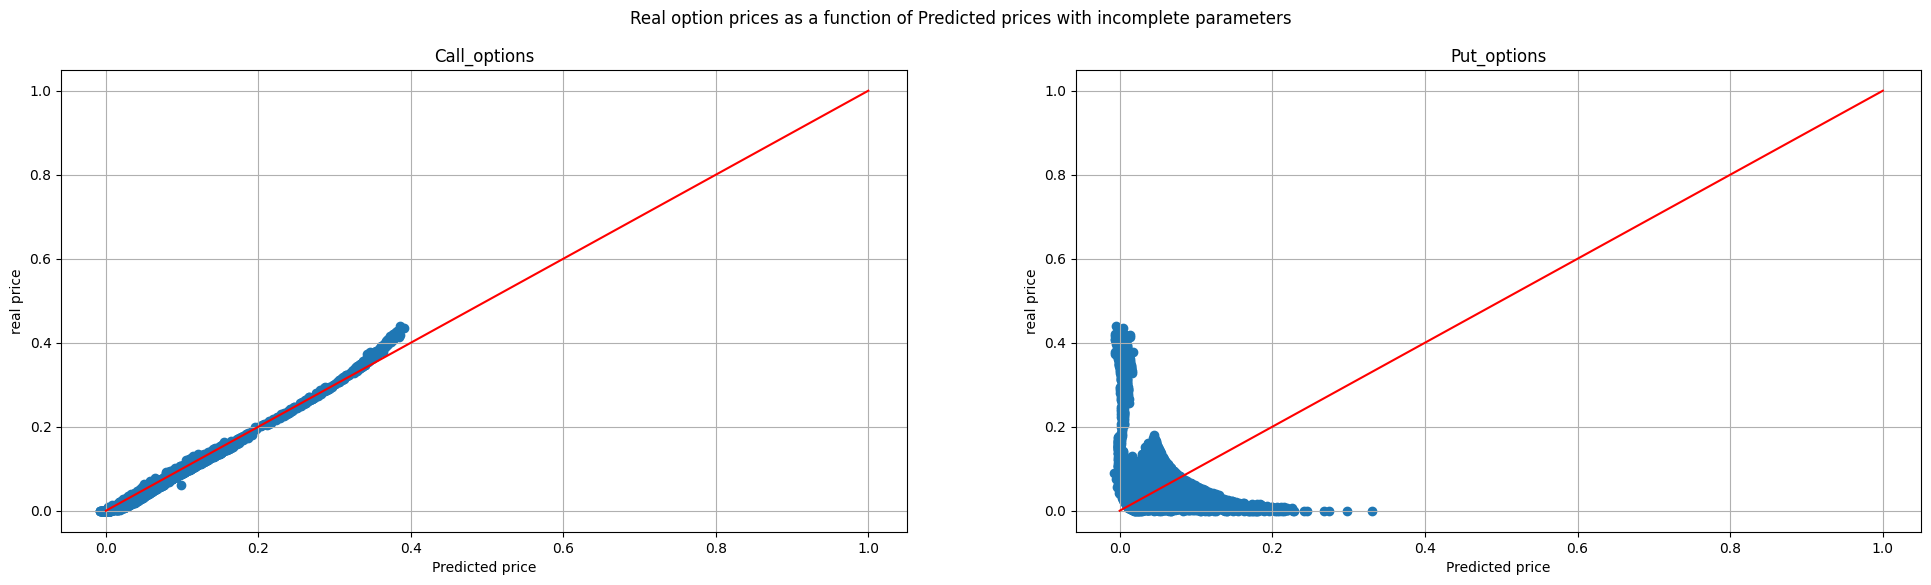

In [40]:
diagonal=np.linspace(0,1,50)
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Real option prices as a function of Predicted prices with incomplete parameters')

axs[0].set_title(r'Call_options')
axs[1].set_title(r'Put_options')

axs[0].scatter(Y_predict_pc[:,0],Y_test_pc[:,0])
axs[0].plot(diagonal,diagonal,color='r', label='First diagonal')

axs[1].scatter(Y_predict_pc[:,1],Y_test_pc[:,0])
axs[1].plot(diagonal,diagonal,color='r', label='First diagonal')

for i in [0,1]:
    axs[i].set_xlabel('Predicted price')
    axs[i].set_ylabel('real price')
    axs[i].grid()

plt.show()

Adding put prices in the data seems to have improved a lot the prediction of calls, however it is very bad for the puts.
Necessaity of controling the put price prediction using call put parity.

The loss mse seems not adapted to fitting two variables

In [125]:
#modifying loss 
def custom_loss(X):
    def loss_function(y_true, y_pred):
        X_reshaped = tf.reshape(X, (-1, 1))
        X_reshaped = tf.cast(X_reshaped, dtype=tf.float32)
        mid = tf.ones_like(y_pred[:, 0]) 
        mse_ = tf.reduce_mean(tf.square(y_pred - y_true))
        parity_loss = tf.reduce_mean(tf.square(y_pred[:, 0] - y_pred[:, 1] - mid + X_reshaped))
        return mse_ + parity_loss

    return loss_function

In [126]:
#DNN with custom loss
def DNN_pc_custom_loss(N_input,X, act='tanh'):
    model = keras.models.Sequential()
    model.add(Dense(12, input_dim=N_input, activation=act))
    model.add(Dense(12, activation=act))
    model.add(Dense(12, activation=act))
    model.add(Dense(12, activation=act))
    model.add(Dense(2, activation=act))

    # Use the custom loss function with X as a parameter
    model.compile(loss=custom_loss(X), optimizer='adam')

    return model

In [127]:
strike_scaled=Put_Call_options.loc[:Train_data_2_size-1,'strike_scaled_call'].values

In [128]:
model_pc_custom_loss=DNN_pc_custom_loss(N_pc_1,strike_scaled,act='tanh')
model_pc_custom_loss.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 12)                84        
                                                                 
 dense_81 (Dense)            (None, 12)                156       
                                                                 
 dense_82 (Dense)            (None, 12)                156       
                                                                 
 dense_83 (Dense)            (None, 12)                156       
                                                                 
 dense_84 (Dense)            (None, 2)                 26        
                                                                 
Total params: 578 (2.26 KB)
Trainable params: 578 (2.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
strike_scaled=strike_scaled.reshape(strike_scaled.shape[0],1)


In [89]:
strike_scaled.shape

(14915, 1)

In [129]:
if Trained_model_put_call_custom==False:
    model_pc_custom_loss.fit(X_train_pc,Y_train_pc,batch_size=64,epochs=30)
    save_model(model_pc_custom_loss, 'model_pc_custom_loss.h5')
else:
    model_pc_custom_loss=load_model('model_pc_custom_loss.h5')

Epoch 1/30
234/234 [==============================] - 5s 11ms/step - loss: 0.0158
Epoch 2/30
234/234 [==============================] - 2s 10ms/step - loss: 0.0121
Epoch 3/30
234/234 [==============================] - 2s 10ms/step - loss: 0.0121
Epoch 4/30
234/234 [==============================] - 3s 11ms/step - loss: 0.0121
Epoch 5/30
234/234 [==============================] - 3s 11ms/step - loss: 0.0121
Epoch 6/30
234/234 [==============================] - 3s 11ms/step - loss: 0.0121
Epoch 7/30
234/234 [==============================] - 3s 12ms/step - loss: 0.0120
Epoch 8/30
234/234 [==============================] - 2s 9ms/step - loss: 0.0120
Epoch 9/30
234/234 [==============================] - 2s 9ms/step - loss: 0.0120
Epoch 10/30
234/234 [==============================] - 2s 10ms/step - loss: 0.0118
Epoch 11/30
234/234 [==============================] - 3s 11ms/step - loss: 0.0116
Epoch 12/30
234/234 [==============================] - 3s 11ms/step - loss: 0.0116
Epoch 13/30
234

C:\Users\Win10-Space\AppData\Local\Temp\ipykernel_8712\4275408723.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_pc_custom_loss, 'model_pc_custom_loss.h5')


In [130]:
Y_predict_pc_custom=model_pc_custom_loss.predict(X_test_pc)

156/156 [==============================] - 0s 2ms/step


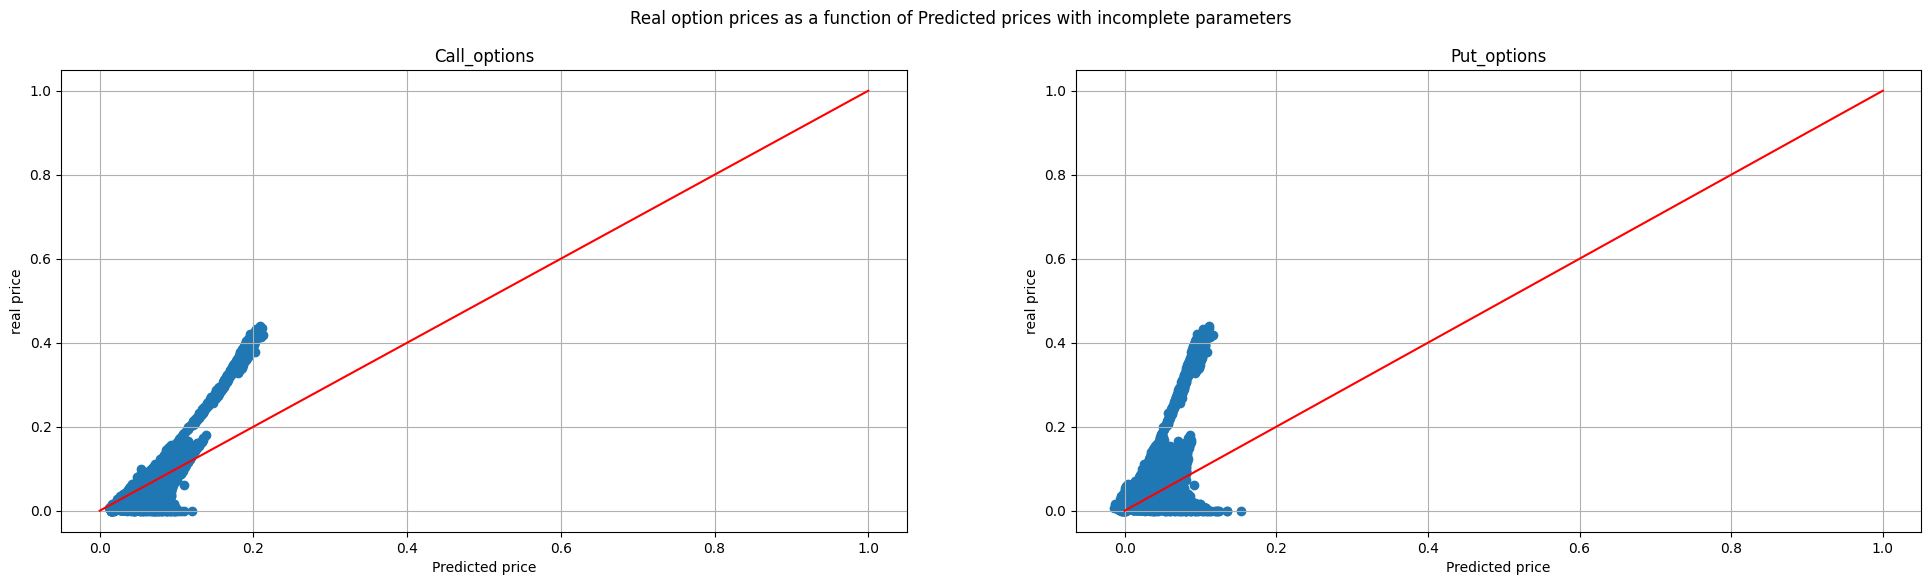

In [131]:
diagonal=np.linspace(0,1,50)
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Real option prices as a function of Predicted prices with incomplete parameters')

axs[0].set_title(r'Call_options')
axs[1].set_title(r'Put_options')

axs[0].scatter(Y_predict_pc_custom[:,0],Y_test_pc[:,0])
axs[0].plot(diagonal,diagonal,color='r', label='First diagonal')

axs[1].scatter(Y_predict_pc_custom[:,1],Y_test_pc[:,0])
axs[1].plot(diagonal,diagonal,color='r', label='First diagonal')

for i in [0,1]:
    axs[i].set_xlabel('Predicted price')
    axs[i].set_ylabel('real price')
    axs[i].grid()

plt.show()

Not sure if we get an improvement of results or not. However we could see that prediction of the puts have improved over a less good prediction of calls.